In [5]:
import h5py
import logging

import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from tqdm import trange
from numpy.testing import assert_allclose

from swfe.swe_2d import ShallowTwo, ShallowTwoFilter
from statfenics.utils import build_observation_operator

# load extension and check it's OK
%load_ext line_profiler

logging.basicConfig(level=logging.INFO)
fe.set_log_level(50)

In [7]:
# physical settings
period = 120.
nu = 1e-6
g = 9.8

# reference values
u_ref = 0.01  # cm/s
length_ref = 0.1  # cylinder
time_ref = length_ref / u_ref
H_ref = length_ref

# compute reynolds number
Re = u_ref * length_ref / nu

params = dict(
    nu=1 / Re, g=g * length_ref / u_ref**2, C=0., H=0.053 / H_ref,
    u_inflow=0.004 / u_ref, inflow_period=period / time_ref,
    length=20., width=10.)
control = dict(
    dt=5e-2,
    theta=0.5,
    simulation="laminar",
    use_imex=False,
    use_les=False)

mesh = "../mesh/branson-mesh-nondim.xdmf"
swe = ShallowTwoFilter(mesh, params, control, comm=fe.MPI.comm_world)

# check that all the dofs line up
assert_allclose(np.unique(swe.W.dofmap().dofs()),
                np.unique(np.concatenate((swe.u_dofs,
                                          swe.v_dofs,
                                          swe.h_dofs))))
swe.setup_form()
swe.setup_solver()

INFO:swfe.swe_2d:reading mesh from file
INFO:swfe.swe_2d:mesh has 30914 elements
INFO:swfe.swe_2d:dx(max) = 0.16463, dx(min): 0.01647
INFO:swfe.swe_2d:CFL number is 1.214464
INFO:swfe.swe_2d:using mumps solver with default PC


In [8]:
# setup filter (basically compute prior additive noise covariance)
rho = 1e-3
ell = 2.
k = 16
stat_params = dict(rho_u=rho, rho_v=rho, rho_h=0.,
                   ell_u=ell, ell_v=ell, ell_h=ell,
                   k_init_u=k, k_init_v=k, k_init_h=0, k=32)
swe.setup_filter(stat_params)

INFO:statfenics.covariance:Eigenvalues converged: 17
INFO:statfenics.covariance:Laplacian eigenvalues: [0.49538112 0.49889808 0.79504997 0.81095127 1.28545657 1.32998194
 1.65461323 1.67887616 1.88845461 1.94320277 1.97801673 2.05393685
 2.29468523 2.47632819 2.70765522 2.88391652]
INFO:swfe.swe_2d:Spectral diff (u): 7.8578e-08, 9.3316e-06
INFO:statfenics.covariance:Eigenvalues converged: 17
INFO:statfenics.covariance:Laplacian eigenvalues: [0.49538112 0.49889808 0.79504997 0.81095127 1.28545657 1.32998194
 1.65461323 1.67887616 1.88845461 1.94320277 1.97801673 2.05393685
 2.29468523 2.47632819 2.70765522 2.88391652]
INFO:swfe.swe_2d:Spectral diff (v): 7.8578e-08, 9.3316e-06


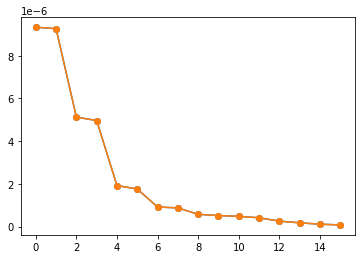

In [9]:
plt.plot(swe.Ku_vals, "o-")
plt.plot(swe.Kv_vals, "o-")
plt.show()

In [10]:
t = 0.
t_final = 0.25 * period / time_ref
nt = np.int32(np.round(t_final / control["dt"]))

In [14]:
t += swe.dt
%lprun -f swe.assemble_derivatives swe.prediction_step(t)
swe.set_prev()

INFO:swfe.swe_2d:Prop. variance kept in reduction: 0.98785


Timer unit: 1e-06 s

Total time: 1.07079 s
File: /home/connor/Projects/20220609-swfe/swfe/swfe/swe_2d.py
Function: assemble_derivatives at line 466

Line #      Hits         Time  Per Hit   % Time  Line Contents
   466                                               def assemble_derivatives(self):
   467         1     517638.0 517638.0     48.3          fe.assemble(self.J, tensor=self.J_mat)
   468         1     522117.0 522117.0     48.8          fe.assemble(self.J_prev, tensor=self.J_prev_mat)
   469                                           
   470                                                   # set things up appropriately
   471         3          5.0      1.7      0.0          for J in [self.J_mat, self.J_prev_mat]:
   472         4        345.0     86.2      0.0              for bc in self.bcs: bc.apply(J)
   473                                           
   474                                                   # TODO(connor): re-use sparsity pattern and speed-up
   475        

In [2]:
means = np.zeros((nt, swe.mean.shape[0]))
variances = np.zeros((nt, swe.mean.shape[0]))
eff_ranks = np.zeros((nt, ))

i_dat = 0
for i in trange(nt):
    t += swe.dt
    swe.inlet_velocity.t = t
    swe.prediction_step(t)
    
    means[i, :] = swe.mean.copy()
    variances[i, :] = np.sum(swe.cov_sqrt**2, axis=1)
    eff_ranks[i] = swe.eff_rank
    logging.info('Effective rank: %.5f', swe.eff_rank)
    
    swe.set_prev()

NameError: name 'np' is not defined

In [ ]:
vel, h = swe.du.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

In [ ]:
var_v = np.sqrt(np.sum(swe.cov_sqrt**2, axis=1))
var_f = fe.Function(swe.W)
var_f.vector().set_local(var_v)

vel, h = var_f.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

In [ ]:
t += swe.dt
%load_ext line_profiler
%lprun -f swe.prediction_step swe.prediction_step(t)
swe.set_prev()